In [64]:
import numpy as np
import matplotlib.pyplot as plt
import ot
from utils import plot_joint_distribution, plot_precomputed_pdf

np.random.seed(123456)

In [122]:
n=100
time_steps = 4

x = np.arange(n,dtype = np.float128)

# pi_1 = 0.6 * ot.datasets.get_1D_gauss(n,25,9) + 0.4 * ot.datasets.get_1D_gauss(n,50,5)
# pi_2 = 0.55 * ot.datasets.get_1D_gauss(n,35,9) + 0.45 * ot.datasets.get_1D_gauss(n,55,5)
pi_i = []
pi_mu_start = (20, 50) 
pi_mu_end = (40, 40)
for i in range(time_steps):
    pi_i.append(0.6 * ot.datasets.get_1D_gauss(n,pi_mu_start[0]+(pi_mu_end[0]-pi_mu_start[0])*i/(time_steps-1),5) 
                 + 0.4 * ot.datasets.get_1D_gauss(n,pi_mu_start[1]-(pi_mu_start[1]-pi_mu_end[1])*i/(time_steps-1),5).astype(np.float128))
pi_i = np.array(pi_i)


Q_i = []
Q_sigma_start = 5
Q_sigma_end = 5
Q_mu_start = 35
Q_mu_end = 40
for i in range(time_steps):
    print(Q_mu_start+(Q_mu_end-Q_mu_start)*i/(time_steps-1))
    Q_i.append(ot.datasets.get_1D_gauss(n,
                                        Q_mu_start+(Q_mu_end-Q_mu_start)*i/(time_steps-1),
                                        Q_sigma_start+(Q_sigma_end - Q_sigma_start)*i/(time_steps-1)).astype(np.float128))
Q_i = np.array(Q_i)

35.0
36.666666666666664
38.333333333333336
40.0


(<Figure size 1000x800 with 1 Axes>,
 <Axes3D: xlabel='X Axis (Space)', ylabel='Y Axis (Time)', zlabel='Z Axis (Probability Density)'>)

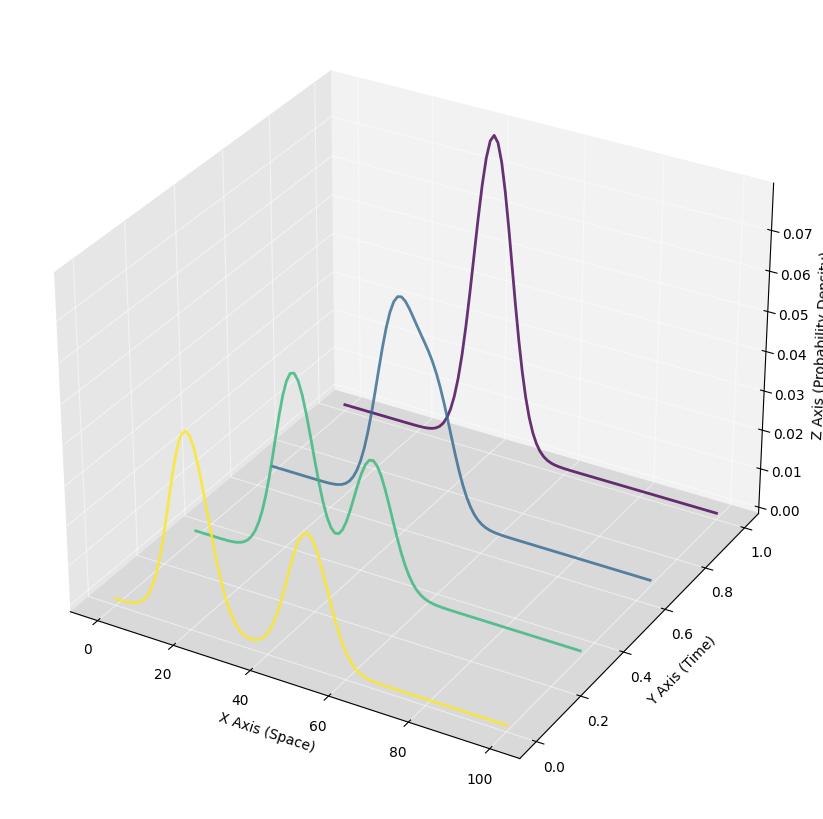

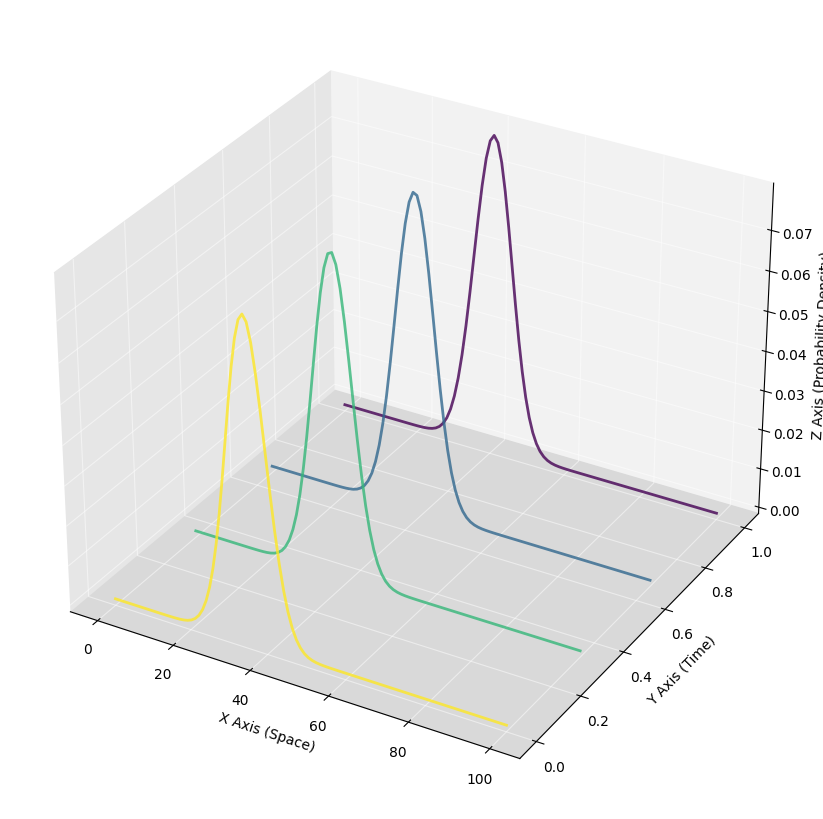

In [123]:
plot_precomputed_pdf(pi_i, 
                     time_range=(0,1), 
                    #  title=r"$\pi_i$"
                    save_dir="output/general_pi.pdf"
                     )
plot_precomputed_pdf(Q_i, 
                     time_range=(0,1), 
                    #  title=r"$\mathbb{Q}_i$"
                    save_dir="output/general_Qi.pdf"
                     )

In [154]:
def ProximalPointOT(mu, nv, C, beta = 2, maxiter = 1000, inner_maxiter = 1, use_path = True, return_map = True, return_loss = True):
    n = len(mu)
    a = np.ones([n,])
    b = a
    T = np.ones((n,n))/n**2
    G = np.exp(-(C/beta))
    loss = []
    for outer_iter in range(maxiter):
        Q = G * T
        for inner_iter in range(inner_maxiter):
            a = mu/(np.matmul(Q,b) + 1e-3)
            b = nv/(np.matmul(np.transpose(Q),a) + 1e-3)
        T = np.expand_dims(a,axis = 1)*Q*np.expand_dims(b,axis = 0)
        WD = np.sum(T*C)
        loss.append(WD)
    return T,loss

def cal_separate_case(Q_01, Q_02,pi_1,pi_2):
    n = len(pi_1)
    # 创建 x1 和 x3 的值
    x1_values = np.arange(n,dtype=np.float128).reshape(n, 1)  # 转换为列向量
    x3_values = np.arange(n,dtype=np.float128).reshape(1, n)  # 转换为行向量

    # 使用 NumPy 的广播计算成本矩阵
    c2 = -np.dot(x1_values, x3_values)
    c2 = (c2 - c2.min())/(c2.max() - c2.min())

    gamma_a,loss = ProximalPointOT(pi_1,Q_01,c2,beta=0.5,maxiter=100,inner_maxiter=20)
    print(loss[-1])
    gamma_a = gamma_a/gamma_a.sum()

    gamma_b,loss = ProximalPointOT(Q_02,pi_2,c2,beta=0.5,maxiter=100,inner_maxiter=20)
    print(loss[-1])
    gamma_b = gamma_b/gamma_b.sum()

    return gamma_a,gamma_b


gamma_a_lst, gamma_b_lst, Q_lst = [], [], []
for i in range(time_steps-1):
    gamma_a, gamma_b = cal_separate_case(Q_i[i], Q_i[i+1], pi_i[i], pi_i[i+1])
    gamma_a_lst.append(gamma_a)
    gamma_b_lst.append(gamma_b)
    Q_lst.append(np.outer(Q_i[i], Q_i[i+1])
)

0.79607546995018745967
0.79059836169760221907
0.790598364200055941
0.7858435140404115845
0.7858435538522017703
0.77793708011937598456


(<Figure size 1000x1000 with 3 Axes>, <Axes: >)

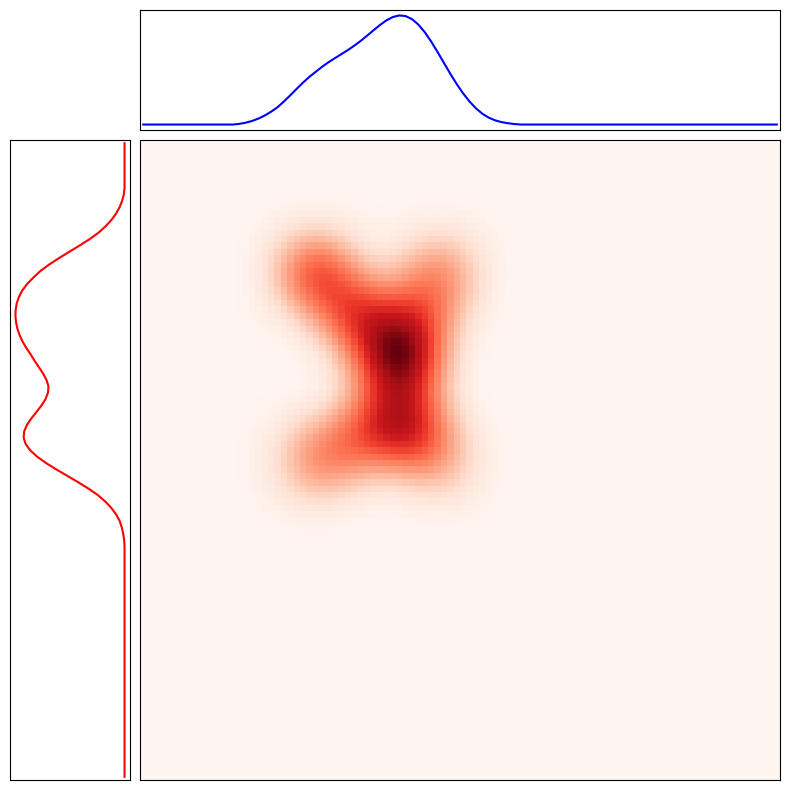

In [156]:
n = len(gamma_a_lst[0])
tilde_gamma = np.zeros((n, n))

for i in range(time_steps-1):
    tilde_gamma += np.einsum('ij,jk,kl->il', gamma_a_lst[i], Q_lst[i], gamma_b_lst[i])
tilde_gamma = tilde_gamma/tilde_gamma.sum()
plot_joint_distribution(tilde_gamma,save_dir="output/general_tilde_gamma.pdf")

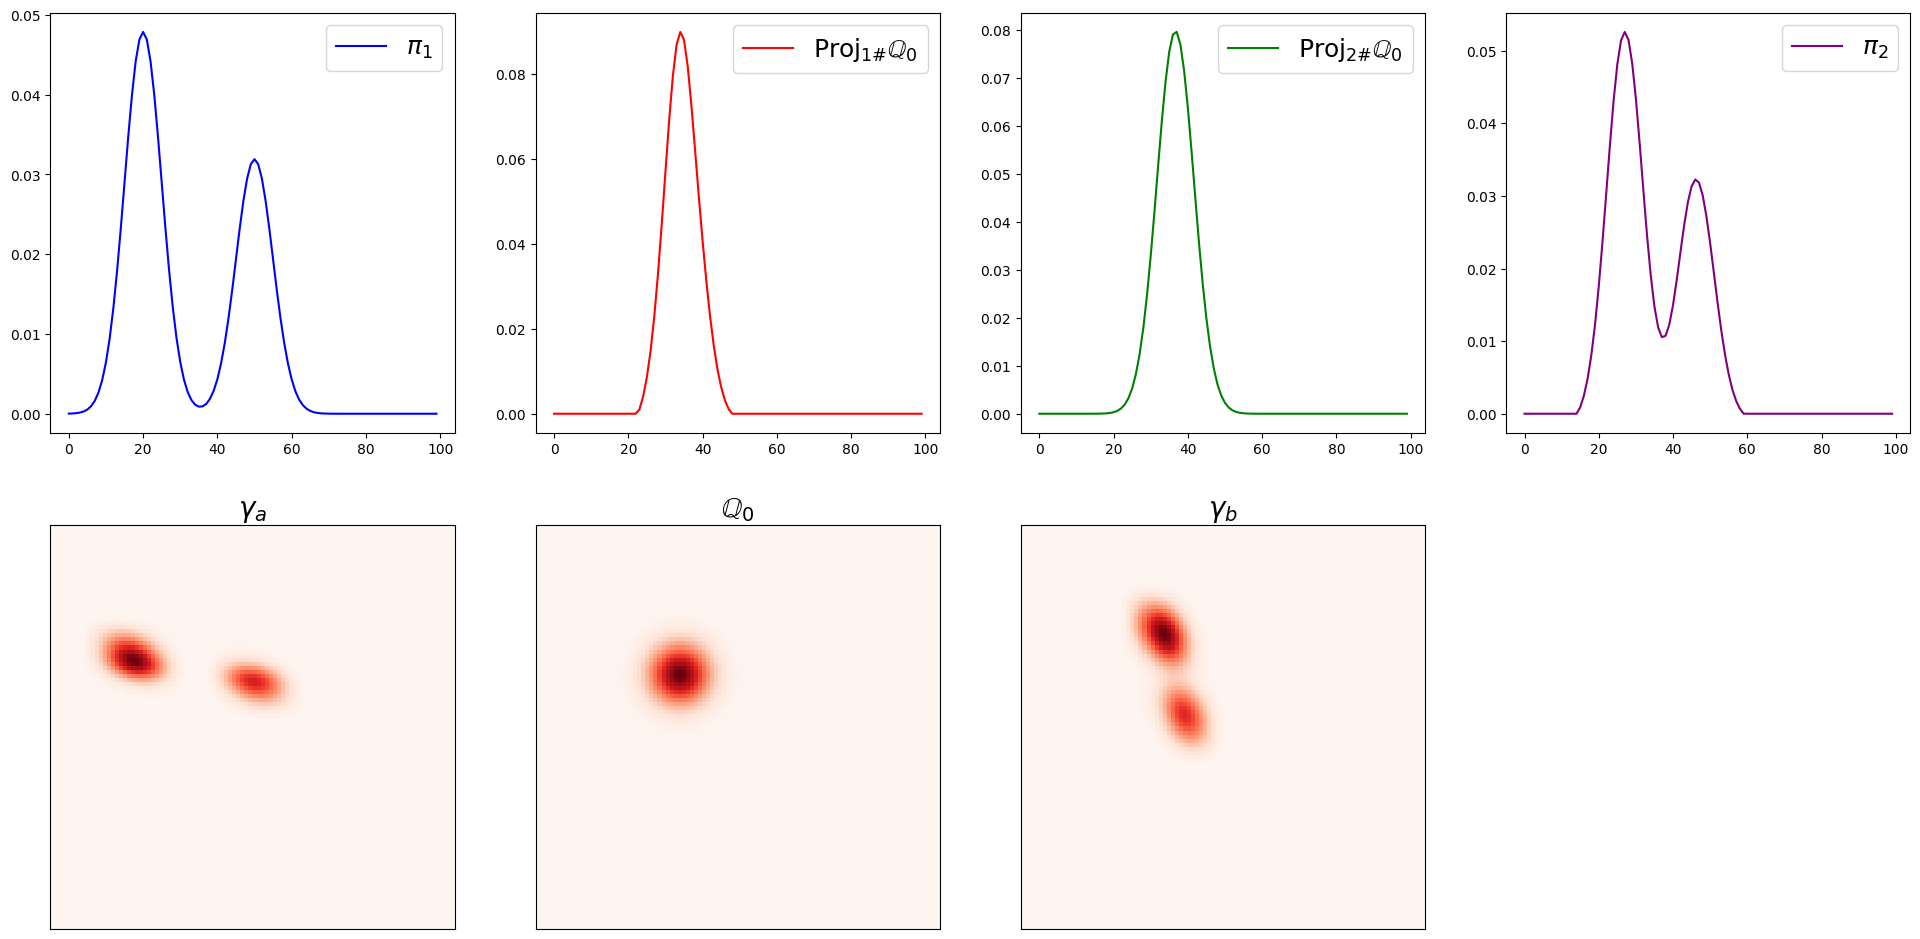

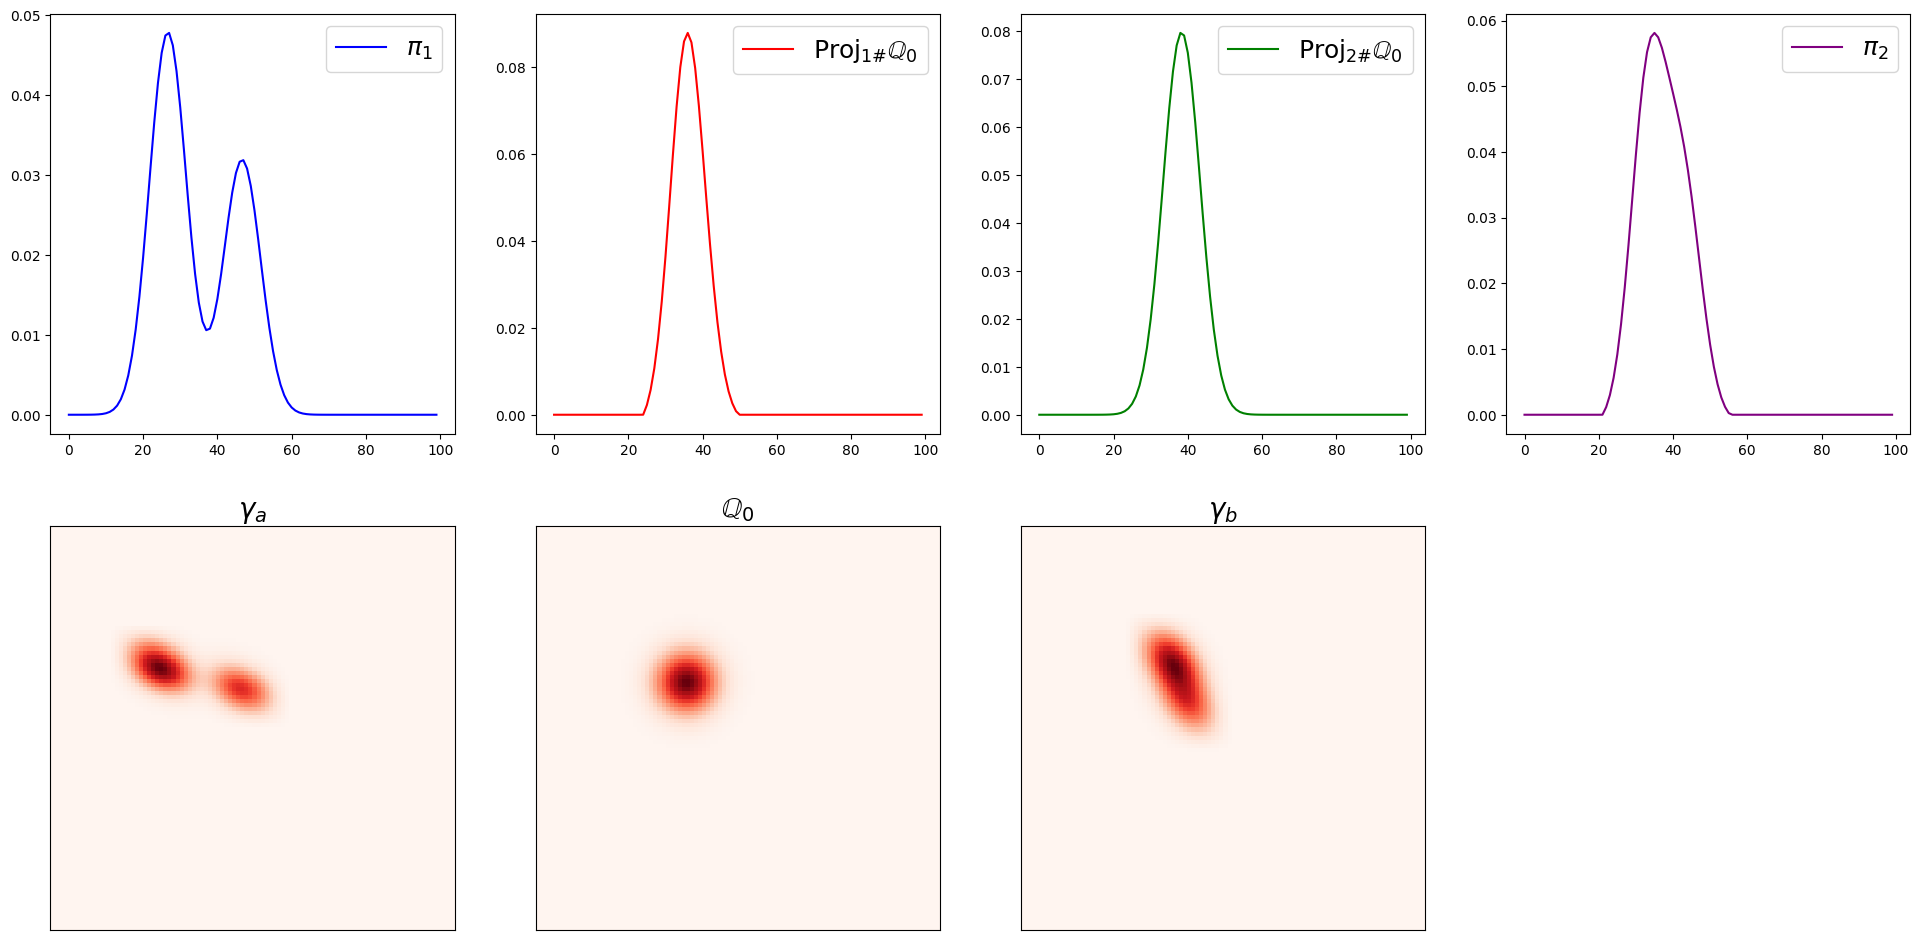

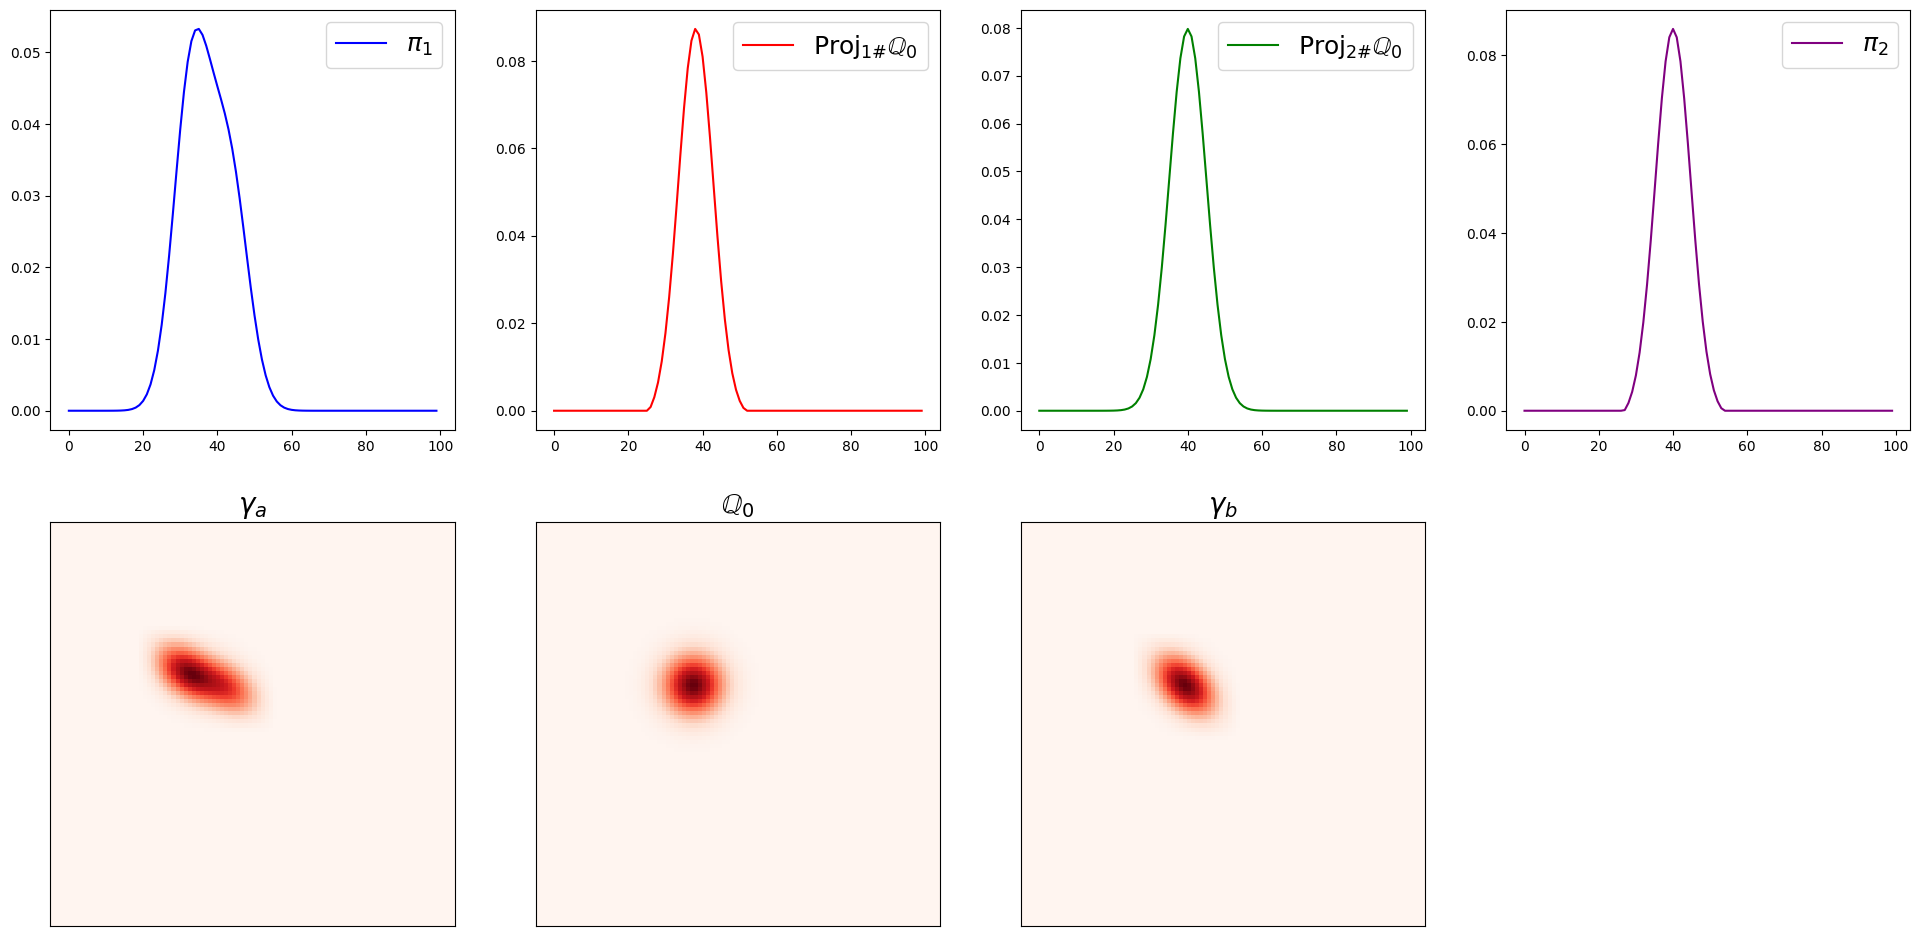

In [157]:
def plot_gamma(pi_1, gamma_a, gamma_b, Q_0, save_dir = None):
    fig,axs = plt.subplots(2,4,figsize = (24,12))
    axs[0][0].plot(x, pi_1, '-', color='blue', label='$\pi_1$')
    cal_Q_01 = np.dot(pi_1, gamma_a)
    cal_Q_01 = cal_Q_01 / cal_Q_01.sum()
    axs[0][1].plot(x, cal_Q_01, '-', color='red', label=r'$\text{Proj}_{1\#}\mathbb{Q}_{0}$')
    cal_Q_02 = np.dot(cal_Q_01,Q_0)
    cal_Q_02 = cal_Q_02 / cal_Q_02.sum()
    axs[0][2].plot(x, cal_Q_02, '-', color='green', label=r'$\text{Proj}_{2\#}\mathbb{Q}_{0}$')
    cal_pi_2 = np.dot(cal_Q_02,gamma_b)
    cal_pi_2 = cal_pi_2 / cal_pi_2.sum()
    axs[0][3].plot(x, cal_pi_2, '-', color='purple', label='$\pi_2$')
    axs[0][0].legend(fontsize=18)
    axs[0][1].legend(fontsize=18)
    axs[0][2].legend(fontsize=18)
    axs[0][3].legend(fontsize=18)

    axs[1][0].imshow(gamma_a.astype(np.float64).T,cmap = 'Reds')
    axs[1][1].imshow(Q_0.astype(np.float64).T,cmap = 'Reds')
    axs[1][2].imshow(gamma_b.astype(np.float64).T,cmap = 'Reds')

    axs[1][0].set_title(r'$\gamma_{a}$', fontsize = 20)
    axs[1][1].set_title(r'$\mathbb{Q}_{0}$', fontsize = 20)
    axs[1][2].set_title(r'$\gamma_{b}$', fontsize = 20)

    # remove the x and y axis outilers  
    axs[1][0].get_xaxis().set_visible(False)
    axs[1][0].get_yaxis().set_visible(False)
    axs[1][1].get_xaxis().set_visible(False)
    axs[1][1].get_yaxis().set_visible(False)
    axs[1][2].get_xaxis().set_visible(False)
    axs[1][2].get_yaxis().set_visible(False)
    axs[1][3].set_visible(False)

    if save_dir:
        fig.savefig(save_dir, bbox_inches='tight')

for i in range(time_steps-1):
    plot_gamma(pi_i[i], gamma_a_lst[i], gamma_b_lst[i], Q_lst[i], save_dir=f"output/general_gamma_{i}.pdf")